# Explore here

In [1]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib
from sklearn.linear_model import LinearRegression, Lasso

In [2]:
def calculate_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular las métricas para entrenamiento
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)*100
    r2_train = r2_score(y_train, y_pred_train)

    # Calcular las métricas para test
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)*100
    r2_test = r2_score(y_test, y_pred_test)

    # Calcular las diferencias
    mae_diff = mae_test - mae_train
    mape_diff = mape_test - mape_train
    r2_diff = r2_test - r2_train

    # Crear el DataFrame
    metrics_df = pd.DataFrame({
        'MAE': [mae_train, mae_test, mae_diff],
        'MAPE': [mape_train, mape_test, mape_diff],
        'R2': [r2_train, r2_test, r2_diff]
    }, index=['Train', 'Test', 'Difference'])

    return metrics_df

In [3]:
# Leer csv
df = pd.read_csv('/workspaces/pille9-regularized-linear-regression/data/raw/demographic_health_data.csv')
pd.set_option('display.max_columns', None)
df.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,158,455,11.8,9.6,2.2,0.0,0.7,0.6,4204,12119,10552,10291,11.3,32.6,28.4,27.7,7587,13.8,19.3,19.5,59338,53628,65048,25957,25015,942,3.6,59338,119.0,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,Autauga,Alabama,1,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,5403,2190,10.5,10.3,0.1,0.5,24.3,24.8,14310,40579,46025,46075,9.7,27.6,31.3,31.3,21069,9.8,13.9,13.1,57588,54437,60739,93849,90456,3393,3.6,57588,115.5,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,Baldwin,Alabama,1,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.3

VARIABLE OBJETIVO: OBESITY_PREVALENCE


In [4]:
df.shape

(3140, 108)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [6]:
# Analizar constantes
n_unicos = df.nunique()
n_unicos

fips                      3140
TOT_POP                   3074
0-9                       2723
0-9 y/o % of total pop    3136
19-Oct                    2743
                          ... 
CKD_prevalence              43
CKD_Lower 95% CI            39
CKD_Upper 95% CI            46
CKD_number                1894
Urban_rural_code             6
Length: 108, dtype: int64

In [7]:
# Revisar duplicados
df.duplicated().sum()

np.int64(0)

In [8]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fips,3140.0,NaN,NaN,NaN,30401.640764,15150.559265,1001.0,18180.5,29178.0,45081.5,56045.0
TOT_POP,3140.0,NaN,NaN,NaN,104189.41242,333583.395432,88.0,10963.25,25800.5,67913.0,10105518.0
0-9,3140.0,NaN,NaN,NaN,12740.302866,41807.301846,0.0,1280.5,3057.0,8097.0,1208253.0
0-9 y/o % of total pop,3140.0,NaN,NaN,NaN,11.871051,2.124081,0.0,10.594639,11.802727,12.95184,25.460677
19-Oct,3140.0,NaN,NaN,NaN,13367.976752,42284.392134,0.0,1374.5,3274.0,8822.25,1239139.0
...,...,...,...,...,...,...,...,...,...,...,...
CKD_prevalence,3140.0,NaN,NaN,NaN,3.446242,0.568059,1.8,3.1,3.4,3.8,6.2
CKD_Lower 95% CI,3140.0,NaN,NaN,NaN,3.207516,0.52774,1.7,2.9,3.2,3.5,5.8
CKD_Upper 95% CI,3140.0,NaN,NaN,NaN,3.710478,0.613069,1.9,3.3,3.7,4.1,6.6
CKD_number,3140.0,NaN,NaN,NaN,2466.234076,7730.422067,3.0,314.75,718.0,1776.25,237766.0


In [9]:
# Comprobar valores faltantes
df.isnull().mean()*100

fips                      0.0
TOT_POP                   0.0
0-9                       0.0
0-9 y/o % of total pop    0.0
19-Oct                    0.0
                         ... 
CKD_prevalence            0.0
CKD_Lower 95% CI          0.0
CKD_Upper 95% CI          0.0
CKD_number                0.0
Urban_rural_code          0.0
Length: 108, dtype: float64

In [10]:
df.isnull().any(axis=1).mean()*100

np.float64(0.0)

In [11]:
# Revisar columnas con valores idénticos
for col1 in df.columns:
    for col2 in df.columns:
        if col1 != col2 and df[col1].equals(df[col2]):
            print(f"Las columnas '{col1}' y '{col2}' son idénticas.")

Las columnas 'TOT_POP' y 'POP_ESTIMATE_2018' son idénticas.
Las columnas 'POP_ESTIMATE_2018' y 'TOT_POP' son idénticas.
Las columnas 'MEDHHINC_2018' y 'Median_Household_Income_2018' son idénticas.
Las columnas 'Median_Household_Income_2018' y 'MEDHHINC_2018' son idénticas.


In [12]:
# Elimino una de cada par de columnas
df.drop(columns=["POP_ESTIMATE_2018", "Median_Household_Income_2018"], inplace=True)

In [13]:
df['fips']

0        1001
1        1003
2        1005
3        1007
4        1009
        ...  
3135    56037
3136    56039
3137    56041
3138    56043
3139    56045
Name: fips, Length: 3140, dtype: int64

In [14]:
df['CNTY_FIPS']


0        1
1        3
2        5
3        7
4        9
        ..
3135    37
3136    39
3137    41
3138    43
3139    45
Name: CNTY_FIPS, Length: 3140, dtype: int64

In [15]:
# Elimino CNTY_FIPS
df.drop(columns=["CNTY_FIPS"])

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,STATE_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,158,455,11.8,9.6,2.2,0.0,0.7,0.6,4204,12119,10552,10291,11.3,32.6,28.4,27.7,7587,13.8,19.3,19.5,59338,53628,65048,25957,25015,942,3.6,119.0,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,Autauga,Alabama,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,5403,2190,10.5,10.3,0.1,0.5,24.3,24.8,14310,40579,46025,46075,9.7,27.6,31.3,31.3,21069,9.8,13.9,13.1,57588,54437,60739,93849,90456,3393,3.6,115.5,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,Baldwin,Alabama,1,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.362847,2244,9.018930,1048,4.212049,12209,49.069571,12042,48.398376,164,0.659137,113,0.4

In [16]:
# Elimino COUNTY_NAME y STATE_NAME
df.drop(columns=["COUNTY_NAME", "STATE_NAME", "STATE_FIPS"], inplace=True)

In [17]:
# Elimino columnas con el símbolo % en el nombre
df = df[[col for col in df.columns if "%" not in col]]

In [18]:
# Elimino columnas con prevalence excepto obesity que es la objetivo
df = df[[col for col in df.columns if "prevalence" not in col.lower() or "Obesity_prevalence" in col]]

In [19]:
# Elimino columnas de intervalos de confianza
df = df[[col for col in df.columns if "CI" not in col]]

In [20]:
# Elimino columnas con la palabra percent
df = df[[col for col in df.columns if "percent" not in col.lower()]]

In [21]:
# Elimino PCTPOVALL_2018 y Unemployment_rate_2018

df.drop(columns=["PCTPOVALL_2018", "Unemployment_rate_2018"], inplace=True)

In [22]:
# Elimino Obesity_number
df.drop(columns=["Obesity_number"], inplace=True)

In [23]:
df.head()

,fips,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,60-69,70-79,80+,White-alone pop,Black-alone pop,Native American/American Indian-alone pop,Asian-alone pop,Hawaiian/Pacific Islander-alone pop,Two or more races pop,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,POVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,CNTY_FIPS,county_pop2018_18 and older,anycondition_number,Obesity_prevalence,Heart disease_number,COPD_number,diabetes_number,CKD_number,Urban_rural_code
0,1001,55601,6787,7637,6878,7089,7582,7738,5826,4050,2014,42660,10915,267,681,62,1016,158,455,11.8,9.6,2.2,0.0,0.7,0.6,4204,12119,10552,10291,7587,19.3,19.5,59338,25957,25015,942,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,1,42438,20181,35.8,3345,3644,5462,1326,3
1,1003,218022,24757,26913,23579,25213,27338,29986,29932,20936,9368,190301,19492,1684,2508,146,3891,5403,2190,10.5,10.3,0.1,0.5,24.3,24.8,14310,40579,46025,46075,21069,13.9,13.1,57588,93849,90456,3393,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,3,170912,68790,29.7,13414,14692,20520,5479,4
2,1005,24881,2732,2960,3268,3201,3074,3278,3076,2244,1048,12209,12042,164,113,46,307,-277,2820,10.4,12.9,-2.5,0.5,-9.1,-8.6,4901,6486,4566,2220,6788,43.9,36.7,34382,8373,7940,433,217.1,196.7,77.2,71.2,7.6,6.9,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,5,19689,11325,40.7,2159,2373,3870,887,6
3,1007,22400,2456,2596,3029,3113,3038,3115,2545,1723,785,17211,4770,98,53,26,242,-155,2151,11.1,11.4,-0.3,0.4,-7.0,-6.6,2650,7471,3846,1813,4400,27.8,26.3,46064,8661,8317,344,217.1,196.7,77.2,71.2,7.6,6.9,11.626493,2.451783,0.462860,10.471635,8.560619,29.063942,0,22580,4773,7,17813,9190,38.7,1533,1789,2511,595,2
4,1009,57840,7095,7570,6742,6884,7474,7844,6965,4931,2335,55456,950,378,185,70,801,13,489,11.8,11.4,0.3,0.1,-0.2,0.0,7861,13489,13267,5010,7527,18.0,15.5,50412,25006,24128,878,217.1,196.7,77.2,71.2,7.6,6.9,30.021267,6.330854,1.195171,27.039257,22.104740,75.047251,6,57667,13600,9,44448,20584,34.0,4101,4661,6017,1507,2


In [24]:
# Separar las variables independientes de la dependiente
X = df.drop(['Obesity_prevalence'], axis=1)
y = df['Obesity_prevalence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Usamos xgb para conocer la importancia de las características
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100})
df_imp = df_imp.sort_values(by='Importance', ascending=False)
df_imp

,Feature,Importance
32,MEDHHINC_2018,15.669910
39,Active Patient Care Primary Care Physicians pe...,13.247972
30,PCTPOV017_2018,7.490224
36,Active Physicians per 100000 Population 2018 (...,5.968319
41,Active Patient Care General Surgeons per 10000...,5.273976
37,Total Active Patient Care Physicians per 10000...,5.194714
38,Active Primary Care Physicians per 100000 Popu...,4.652736
28,Bachelor's degree or higher 2014-18,4.641233
40,Active General Surgeons per 100000 Population ...,4.057251
14,Asian-alone pop,1.926676


In [26]:
# Seleccionamos las características que presentan más de un 1% de importancia
X_train = X_train[df_imp[df_imp.Importance>1]['Feature'].values]
X_test = X_test[df_imp[df_imp.Importance>1]['Feature'].values]

In [27]:
X_train.head()

,MEDHHINC_2018,Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),PCTPOV017_2018,Active Physicians per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Bachelor's degree or higher 2014-18,Active General Surgeons per 100000 Population 2018 (AAMC),Asian-alone pop,R_INTERNATIONAL_MIG_2018,fips,R_birth_2018,R_NET_MIG_2018,Black-alone pop,High school diploma only 2014-18,R_DOMESTIC_MIG_2018,anycondition_number,R_death_2018,Less than a high school diploma 2014-18
1292,50374,87.6,23.3,287.0,6.7,249.7,97.8,3406,7.9,89,1.5,26127,11.3,5.0,337,6396,3.5,10213,10.0,2546
2302,45761,88.2,20.9,320.5,7.2,273.3,100.8,6742,8.7,231,0.0,42121,9.7,-7.4,593,18496,-7.4,19282,13.1,3913
761,54718,74.4,14.8,230.8,6.1,212.0,80.3,3984,6.5,394,0.6,18133,10.7,3.0,1435,10860,2.4,14283,9.2,2678
2194,61849,68.5,12.5,206.7,5.8,189.1,73.9,14803,6.2,1370,0.5,40131,10.6,4.2,1175,19984,3.7,33057,9.1,4804
1241,48413,87.6,27.6,287.0,6.7,249.7,97.8,19318,7.9,4026,2.3,26025,12.0,-0.7,15004,33106,-3.0,49754,10.3,8123


<Axes: >

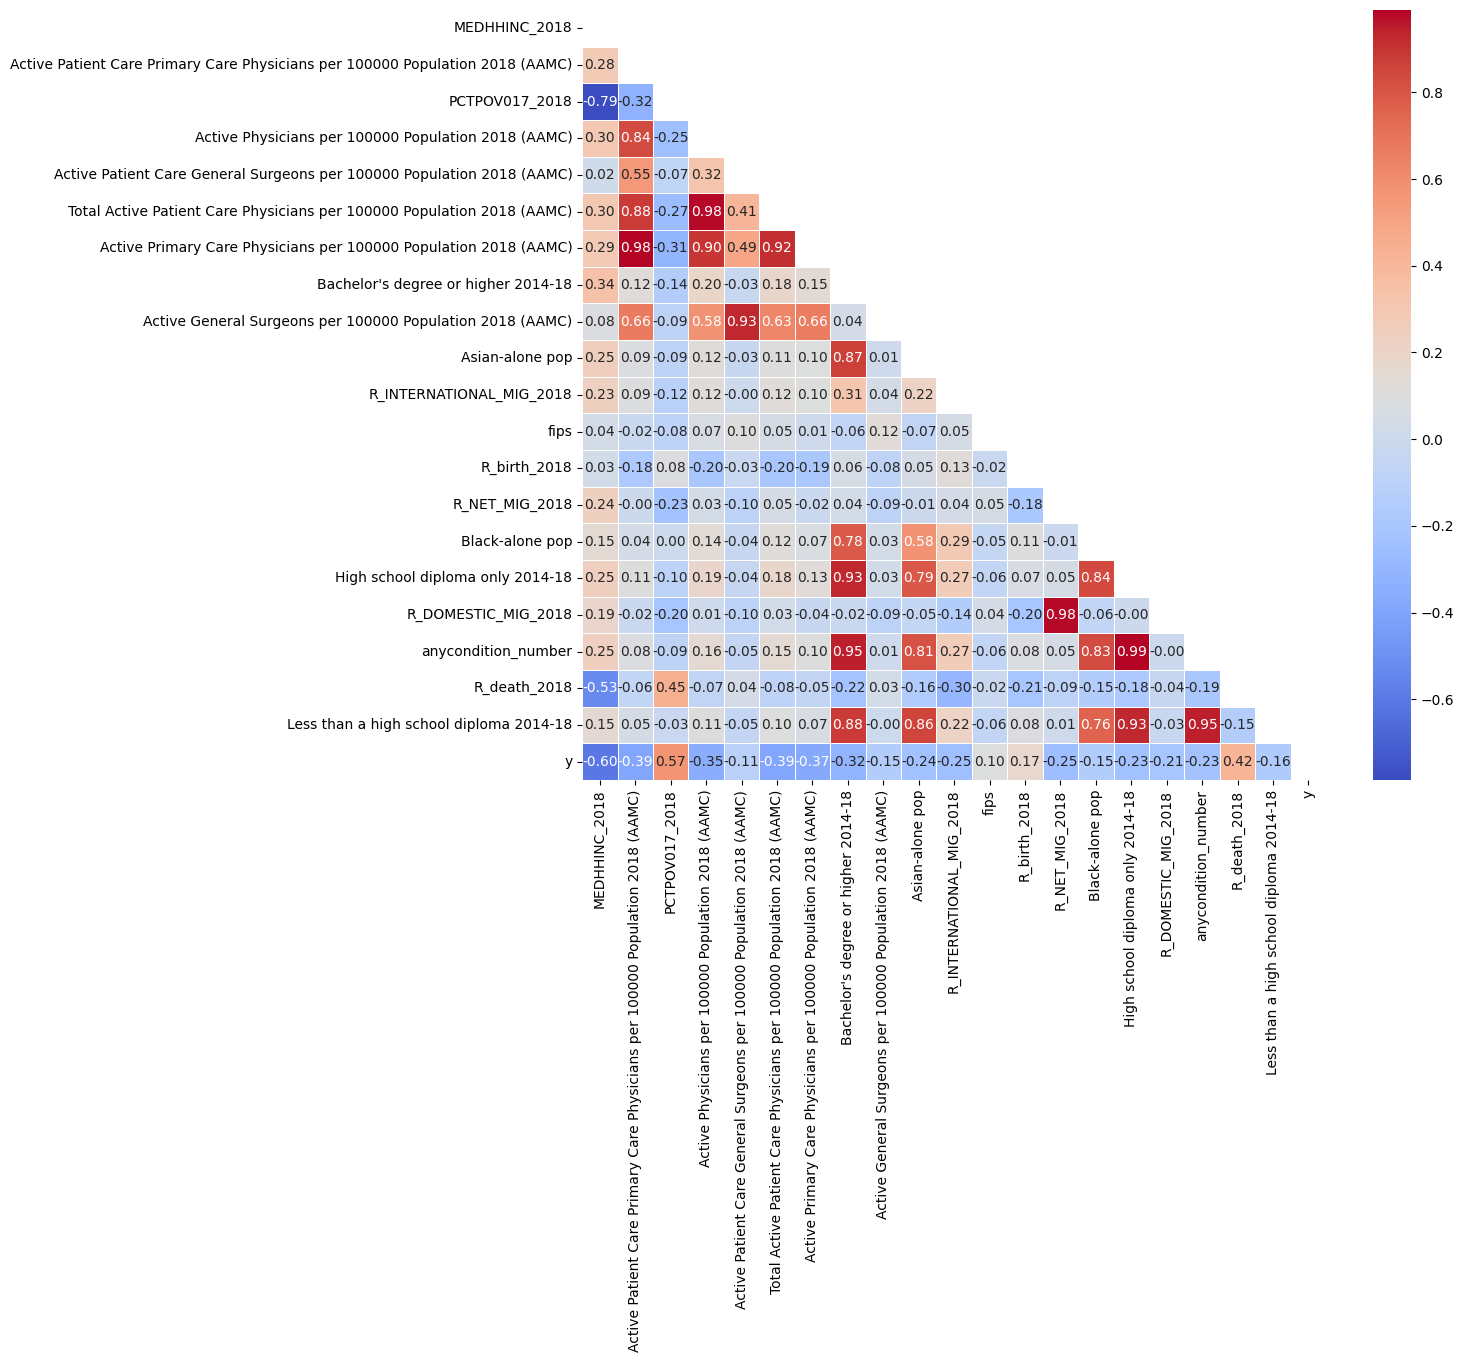

In [28]:
## VIF
X_train.corr()

vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

X_corr = X_train.copy()
X_corr['y'] = y_train
corr = X_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

In [29]:
df_clean = df.drop(columns=["Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)", "Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)", "Active Primary Care Physicians per 100000 Population 2018 (AAMC)", "Active General Surgeons per 100000 Population 2018 (AAMC)", "Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)"])

In [30]:
# Separar las variables independientes de la dependiente
X_clean = df_clean.drop(['Obesity_prevalence'], axis=1)
y_clean = df_clean['Obesity_prevalence']

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [31]:
# Instancio la clase del escalador y lo ajusto con los datos de entrenamiento
scaler = MinMaxScaler().fit(X_train_clean)

In [32]:
# Trasnformamos los datos con el escalador ajustado
X_train_sc = scaler.transform(X_train_clean)
X_test_sc = scaler.transform(X_test_clean)

In [ ]:
# Entrenar modelo de Regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train_sc, y_train_clean)

LinearRegression()

In [34]:
print(f"Intercepto (a): {linear_model.intercept_}")
print(f"Coeficientes (b1, b2): {linear_model.coef_}")

Intercepto (a): 31.305648959032045
Coeficientes (b1, b2): [ 1.97658356e+00 -2.79836598e+00 -2.26361358e+02 -3.72403334e+00
  1.66237279e+01  6.66767117e+01  7.97943045e+01  1.72783772e+02
 -2.60424095e+02  1.18102626e+01  1.34228029e+02 -1.06386592e+01
 -6.69664240e+00 -1.19186831e+01  3.53382780e+01 -1.62710680e+01
  1.43707211e+01  2.48586957e+01  2.83003958e+00  2.80429806e+00
  9.80741414e+00  7.64068261e+00 -4.20085980e+01 -1.48886399e+02
  1.43059845e+02  1.72757906e+02  1.40821040e+02  1.50224649e+02
  2.25226966e+02 -1.03321966e+02  1.87070018e+01 -1.01885490e+01
 -1.01059904e+01 -9.03867531e+01 -9.55527598e+01  1.50859542e+01
 -1.22788607e+01  3.17276628e+01 -2.20567569e+01 -4.95558807e+00
 -1.00530603e+02  2.89030177e+01  1.55373405e+02 -1.49160228e+01
  5.70026336e+02 -2.65980749e+02  7.06624538e-01 -1.39483231e+03
  6.30515375e+02 -9.65854675e+01 -9.63151026e+00 -2.64997691e+02
  3.30461335e+02 -1.52265818e+00]


In [35]:
y_pred_test_linear = linear_model.predict(X_test_sc)
y_pred_test_linear

array([35.78634324, 30.99498105, 39.67445792, 31.48107346, 27.16421131,
       33.25213076, 32.92799201, 39.30081424, 35.92654085, 34.8383959 ,
       34.80743921, 37.04189078, 31.23366927, 36.94506919, 32.07767345,
       37.0343214 , 33.67600547, 38.10367347, 40.73362854, 37.11945435,
       38.21682576, 35.86833319, 33.8396775 , 34.56357975, 38.99238318,
       30.27852235, 25.93715047, 36.17292126, 34.63454259, 39.93530734,
       39.74805711, 41.73623276, 35.15858551, 34.68973675, 30.08488156,
       36.17684648, 37.62936938, 33.47190752, 33.75710808, 32.52674657,
       39.94732106, 37.83334975, 35.56369843, 35.09867516, 31.81450428,
       37.04040436, 36.44447504, 37.56742396, 38.52794203, 37.70252812,
       33.04106809, 40.30382891, 35.84612043, 37.70566235, 36.46564575,
       42.3764184 , 29.49124847, 35.37001936, 35.62292343, 34.13572233,
       26.60415539, 37.08287401, 38.31652759, 27.02066407, 33.5989829 ,
       33.95768905, 35.6560407 , 33.16793057, 35.44672618, 35.12

In [36]:
y_pred_train_linear = linear_model.predict(X_train_sc)

In [37]:
calculate_metrics(y_train_clean, y_test_clean, y_pred_train_linear, y_pred_test_linear)

,MAE,MAPE,R2
Train,2.194069,6.514830,0.609538
Test,2.227291,6.569971,0.602418
Difference,0.033222,0.055141,-0.007120


In [38]:
# Entrenar modelo de Lasso con valores por defecto
lasso_default = Lasso(random_state=42)
lasso_default.fit(X_train_sc, y_train_clean)

Lasso(random_state=42)

In [39]:
y_pred_train_lasso_default = lasso_default.predict(X_train_sc)
y_pred_test_lasso_default = lasso_default.predict(X_test_sc)

In [40]:
calculate_metrics(y_train_clean, y_test_clean, y_pred_train_lasso_default, y_pred_test_lasso_default)

,MAE,MAPE,R2
Train,3.471790,10.612876,0.000000
Test,3.512826,10.527237,-0.000118
Difference,0.041036,-0.085639,-0.000118


Lasso con el valor por defecto no está explicando nada y tiene peor rendimiento que la regresión lineal (α es demasiado alto y elimina demasiadas variables).

In [41]:
# Evolución de R2
alpha_values = np.linspace(0, 20, 50)
r2_scores = []

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X_train_sc, y_train_clean)
    y_pred_test_lasso = lasso.predict(X_test_sc)
    r2_test = r2_score(y_test_clean, y_pred_test_lasso)
    r2_scores.append(r2_test)

/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.019e+04, tolerance: 5.108e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_f

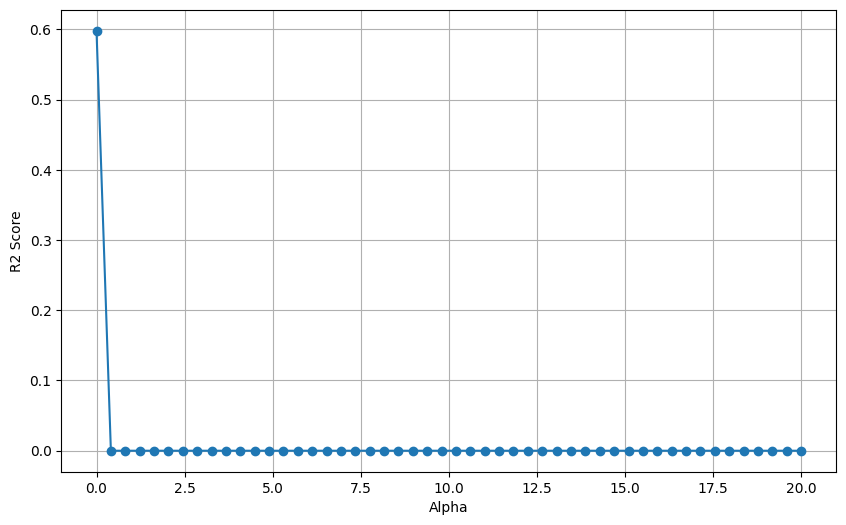

In [42]:
# Graficar la evolución de R2
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, r2_scores, marker='o', linestyle='-')
plt.xlabel("Alpha")
plt.ylabel("R2 Score")
plt.grid()
plt.show()

Para α cercano a 0, R2 ≈ 0.60, lo que significa que el modelo aún explica un porcentaje decente de la variabilidad en los datos. Apenas α crece un poco, R² se desploma hasta casi 0, lo que indica que Lasso está eliminando casi todas las variables del modelo.

In [43]:
# Seleccionamos el mejor alpha y entrenamos el modelo final
best_alpha = alpha_values[np.argmax(r2_scores)]
lasso_opt = Lasso(alpha=best_alpha, random_state=42)
lasso_opt.fit(X_train_sc, y_train_clean)

/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.019e+04, tolerance: 5.108e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_f

Lasso(alpha=np.float64(0.0), random_state=42)

In [44]:
y_pred_train_lasso = lasso_opt.predict(X_train_sc)
y_pred_test_lasso = lasso_opt.predict(X_test_sc)

In [45]:
calculate_metrics(y_train_clean, y_test_clean, y_pred_train_lasso, y_pred_test_lasso)

,MAE,MAPE,R2
Train,2.225603,6.609814,0.600983
Test,2.252815,6.639342,0.597938
Difference,0.027212,0.029528,-0.003046


Lasso con α óptimo funciona casi igual que la regresión lineal. Aunque presenta ligeramente menos diferencia entre train y test, lo que puede indicar mejor generalización